## Initial code

In [1]:
import os
import sys


curr_dir = os.getcwd()
parent_dir = os.path.dirname(curr_dir)
sys.path.append(parent_dir)


import psutil
from utils import check_and_install
    
# List of packages to check, with any special names or setup functions
packages = [
    "pandas",
    "numpy",
    "matplotlib",
    "seaborn",
    "scikit-learn",
    "scipy",
    "tqdm",
    "pandarallel",
    "thinc",
    "srsly",
    "fastai",
    "matplotlib-venn",
    "ipympl"

]

# Loop through each package, importing and installing if needed
for package in packages:
    check_and_install(package)


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from multiprocessing import Pool
from matplotlib_venn import venn3



from pandarallel import pandarallel

real_cpu_count = psutil.cpu_count(logical=False)
pandarallel.initialize(progress_bar=True)


scikit-learn not found, installing...
scikit-learn has been installed
matplotlib-venn not found, installing...
matplotlib-venn has been installed
INFO: Pandarallel will run on 16 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [2]:
DatasetRaces = pd.read_csv("../dataset/races_filled.csv")
DatasetCyclists = pd.read_csv("../dataset/cyclists_filled.csv")

MergedDataset = pd.merge(DatasetCyclists, DatasetRaces.drop(columns=['name']), left_on='_url', right_on='cyclist', suffixes=('_cyclist', '_race')).drop(columns=['_url_cyclist']) 
del MergedDataset['race_year']

print(MergedDataset.duplicated().sum())
print(MergedDataset.isnull().sum())

MergedDataset.sample(3)


0
name                      0
birth_year                0
weight                    0
height                    0
nationality               0
expected_url              0
_url_race                 0
points                    0
uci_points                0
length                    0
climb_total               0
profile                   0
startlist_quality         0
date                      0
position                  0
cyclist                   0
cyclist_age               0
is_tarmac                 0
is_cobbled                0
is_gravel                 0
cyclist_team         158681
delta                     0
dtype: int64


,name,birth_year,weight,height,nationality,expected_url,_url_race,points,uci_points,length,...,startlist_quality,date,position,cyclist,cyclist_age,is_tarmac,is_cobbled,is_gravel,cyclist_team,delta
391357,Pieter Serry,1988.0,66.000000,186.0,Belgium,pieter--serry,giro-d-italia/2023/stage-12,0.0,0.0,185000.0,...,835,2023-05-18 04:30:22,66,pieter-serry,35.0,True,False,False,csf-group-navigare-2008,731.0
63717,Vicente Belda,1954.0,50.139883,154.0,Spain,vicente--belda,vuelta-a-espana/1981/stage-1,0.0,0.0,221000.0,...,457,1981-04-22 06:20:15,60,vicente-belda,27.0,True,False,False,navigare-blue-storm-1993,48.0
354581,Martin Elmiger,1978.0,73.000000,182.0,Switzerland,martin--elmiger,tour-de-suisse/2004/stage-6,0.0,0.0,185400.0,...,676,2004-06-17 05:11:54,28,martin-elmiger,26.0,True,False,False,vini-ricordi-pinarello-sidermec-1986,467.0


In [3]:
outliers_lof = pd.read_csv('../dataset/outliers_lof.csv')
outliers_iso_for = pd.read_csv('../dataset/outliers_iso_for.csv')
outliers_oc_svm_gpu = pd.read_csv('../dataset/outliers_oc_svm.csv')

all_outliers_indexes = outliers_lof.index.union(outliers_iso_for.index).union(outliers_oc_svm_gpu.index)
all_normal_indexes = MergedDataset.index.difference(all_outliers_indexes)

NumericalDataset = MergedDataset.select_dtypes(include=[np.number])

normal_lof = MergedDataset[~MergedDataset['_url_race'].isin(outliers_lof['name_race'])]
normal_iso_for = MergedDataset[~MergedDataset['_url_race'].isin(outliers_iso_for['name_race'])]
normal_oc_svm = MergedDataset[~MergedDataset['_url_race'].isin(outliers_oc_svm_gpu['name_race'])]

normal_lof_num = normal_lof.select_dtypes(include=[np.number])
normal_iso_for_num = normal_iso_for.select_dtypes(include=[np.number])
normal_oc_svm_num = normal_oc_svm.select_dtypes(include=[np.number])

outliers_lof_num = outliers_lof.select_dtypes(include=[np.number])
outliers_iso_for_num = outliers_iso_for.select_dtypes(include=[np.number])
outliers_oc_svm_num = outliers_oc_svm_gpu.select_dtypes(include=[np.number])

normal_lof.sample(3)

,name,birth_year,weight,height,nationality,expected_url,_url_race,points,uci_points,length,...,startlist_quality,date,position,cyclist,cyclist_age,is_tarmac,is_cobbled,is_gravel,cyclist_team,delta
251114,Sebastián Henao,1993.0,57.000000,171.00000,Colombia,sebastian--henao,uae-tour/2022/stage-4,0.0,0.0,181000.0,...,621,2022-02-23 04:54:28,46,sebastian-henao,29.0,True,False,False,team-monex-2005,356.0
538482,René Bittinger,1954.0,69.000000,174.00000,France,rene--bittinger,tour-de-france/1985/stage-21,0.0,0.0,45700.0,...,1470,1985-07-20 01:09:15,76,rene-bittinger,31.0,True,False,False,NaN,384.0
570151,Jos Huysmans,1941.0,60.988501,166.62861,Belgium,jos--huysmans,omloop-het-nieuwsblad/1971/result,35.0,43.0,198000.0,...,574,1971-03-25 04:47:00,7,jos-huysmans,30.0,False,False,False,norway-1987,120.0


## Outliers analysis

Since each run of the algorithms might produce different parameters and different outliers, we will use the outliers generated by the main notebook.

### Outliers feature

In [ ]:
from outliers_code.outliers_analysis import analyze_outlier_characteristics

numerical_features = ['weight', 'height', 'points', 'uci_points', 'length', 
                     'climb_total', 'startlist_quality', 'cyclist_age']

analysis = analyze_outlier_characteristics(MergedDataset.loc[all_normal_indexes], MergedDataset.loc[all_outliers_indexes], numerical_features)

print("Most important features for outliers detection:")
print(analysis['feature_importance'].head(10))
print("\n\n")
print("Summary statistics:")
print(analysis['summary_stats'])

analysis['distribution_plot'].show()

### Outliers difference

#### Venn Diagrams

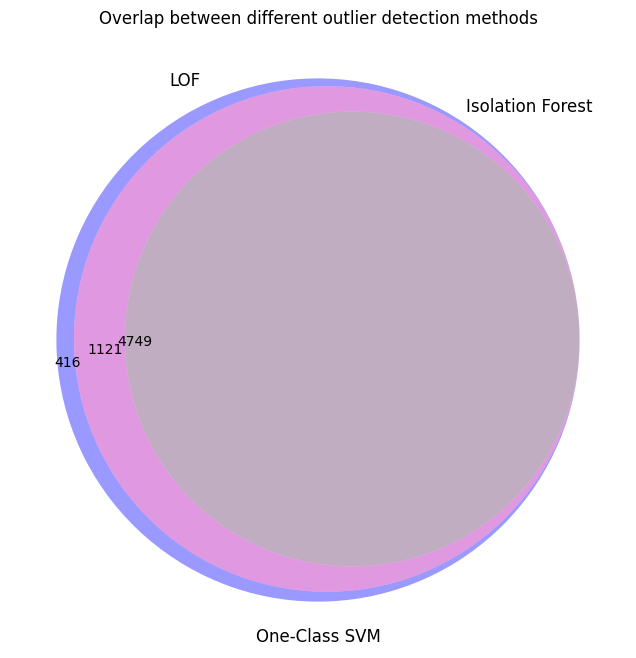

In [ ]:
lof_set = set(outliers_lof.index)
iso_set = set(outliers_iso_for.index)
oc_svm_set = set(outliers_oc_svm_gpu.index)

all_outliers = lof_set | oc_svm_set | iso_set
lof_iso = lof_set & iso_set
lof_oc_svm = lof_set & oc_svm_set
iso_oc_svm = iso_set & oc_svm_set

fig = plt.figure(figsize=(15, 8))

venn3([lof_set, iso_set, oc_svm_set], 
      set_labels=('LOF', 'Isolation Forest', 'One-Class SVM'))
plt.title('Overlap between different outlier detection methods')

plt.show()
plt.close()

#### Outliers

Total cyclist outliers: 6196
Total race outliers: 0

Outlier Analysis Summary:
Total outliers detected: 6286
Cyclist-related outliers: 6196
Race-related outliers: 0
Unclassified outliers: 90

Top 10 Cyclists with highest outlier ratios:
gerard-rue: 100.00%
jan-maas: 100.00%
nathan-van-hooydonck: 100.00%
jose-felix-parra: 100.00%
manuel-penalver: 100.00%
chad-haga: 100.00%
joost-van-leijen: 100.00%
scott-davies: 100.00%
jose-angel-gomez-marchante: 100.00%
giuseppe-guerini: 100.00%

Top 10 Races with highest outlier ratios:
tirreno-adriatico/1979/prologue: 20.00%
tour-de-suisse/1976/stage-1: 20.00%
tour-de-suisse/1975/stage-9b: 16.67%
tirreno-adriatico/1978/prologue: 16.67%
tour-de-suisse/1975/stage-9a: 16.67%
tour-de-suisse/1976/stage-7: 16.67%
tour-de-suisse/1980/stage-7: 16.67%
tour-de-suisse/1981/stage-9: 16.67%
tour-de-suisse/1981/stage-2: 16.67%
tour-de-suisse/1981/stage-6: 16.67%


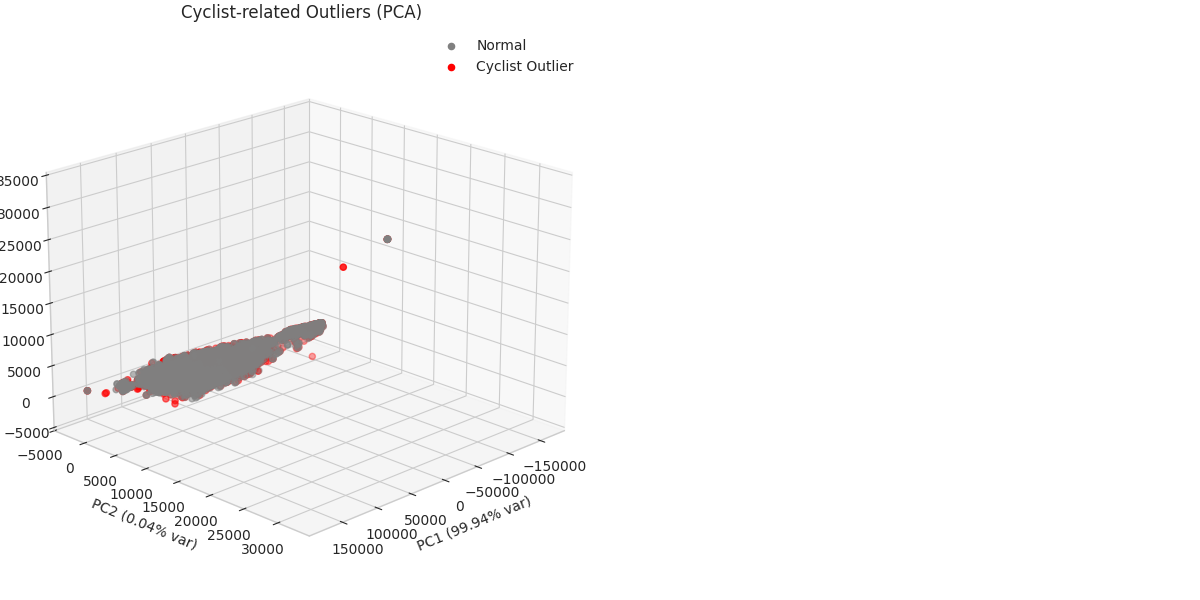

In [5]:
%matplotlib widget
from outliers_code.outliers_analysis import visualize_outlier_types, print_outlier_summary

summary = visualize_outlier_types(
    data=MergedDataset,
    lof_set=outliers_lof.index,
    iso_set=outliers_iso_for.index,
    oc_svm_set=outliers_oc_svm_gpu.index,
    min_races_threshold=5  # Minimum races to consider patterns significant
)

print_outlier_summary(summary)

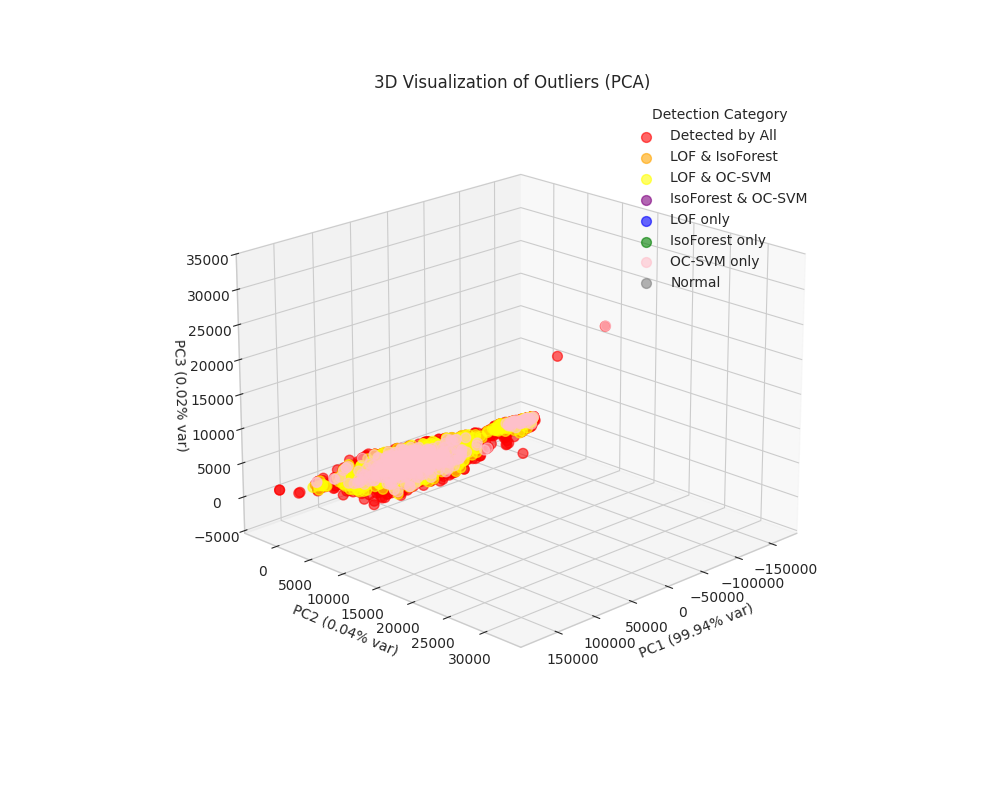

In [ ]:
%matplotlib widget
from outliers_code.outliers_analysis import visualize_outliers_3d

visualize_outliers_3d(NumericalDataset.loc[all_outliers_indexes], lof_set, iso_set, oc_svm_set)


### Z-scores, box plots

In [ ]:
from outliers_code.outliers_analysis import (
    calculate_z_score, 
    plot_outlier_scores, 
    plot_z_score_distributions,    
)

NumericalDataset = normal_lof.select_dtypes(include=[np.number])
stats = NumericalDataset.agg(['mean', 'std'])
data_mean, data_std = stats.loc['mean'], stats.loc['std']



data_tuples = [
    (outliers_lof[NumericalDataset.columns], data_mean, data_std),
    (outliers_iso_for[NumericalDataset.columns], data_mean, data_std),
    (outliers_oc_svm_gpu[NumericalDataset.columns], data_mean, data_std)
]
with Pool() as pool:
    z_scores = pool.map(calculate_z_score, data_tuples)

z_scores_lof, z_scores_iso_for, z_scores_oc_svm = z_scores



#### Histogram plots of outliers z-scores

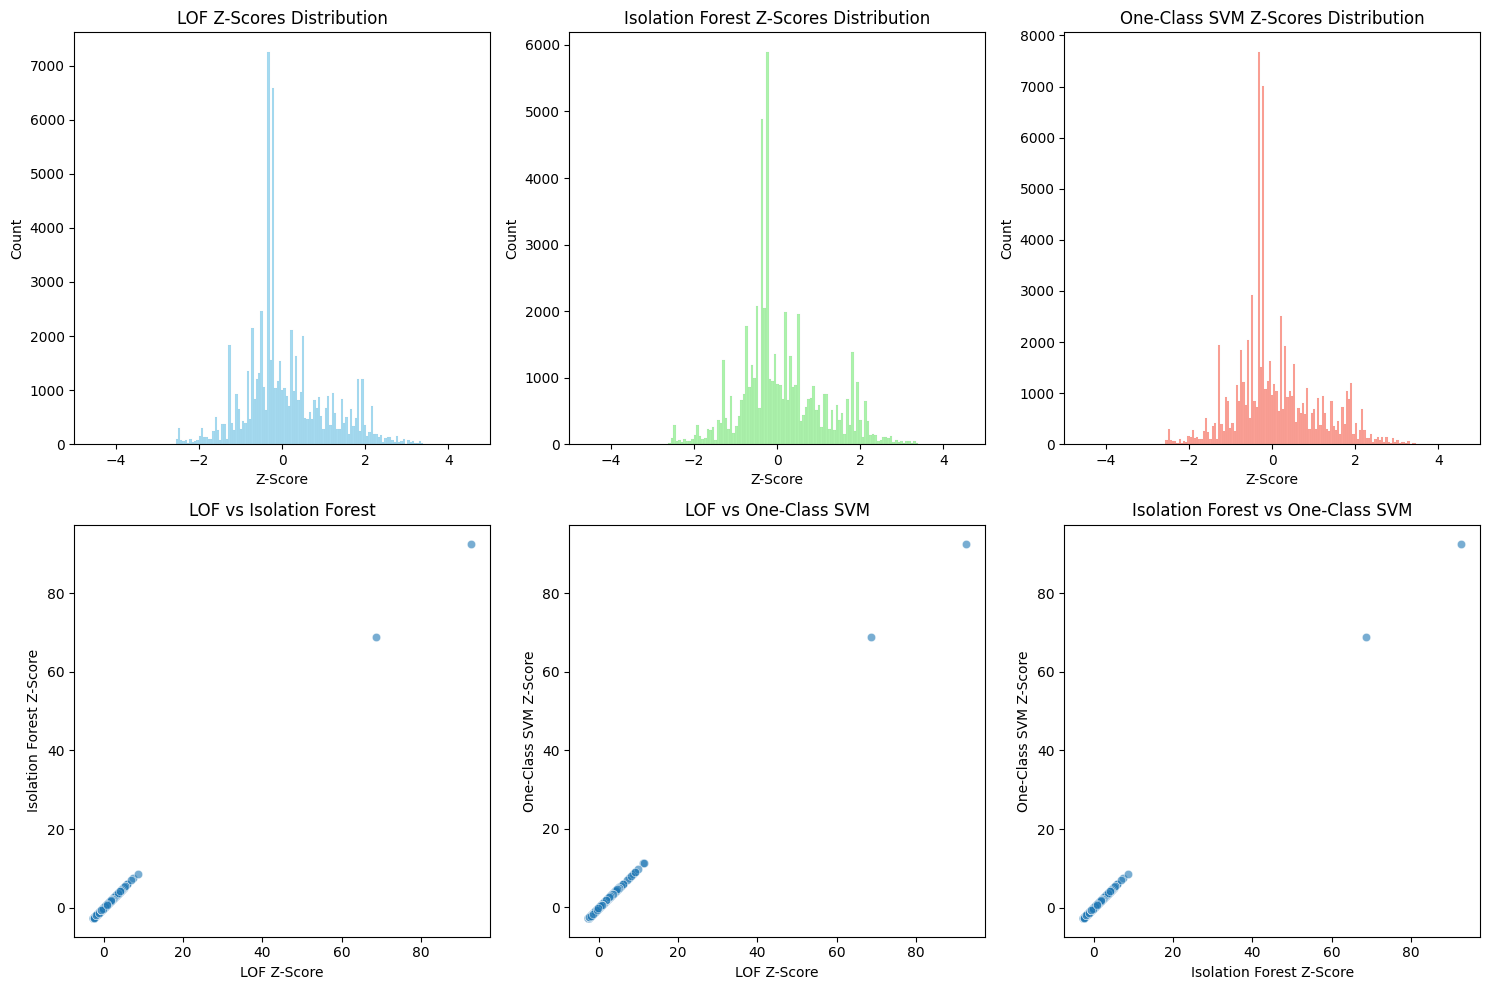

In [ ]:
plot_outlier_scores(z_scores_lof, z_scores_iso_for, z_scores_oc_svm)

#### Box plots of outliers z-scores

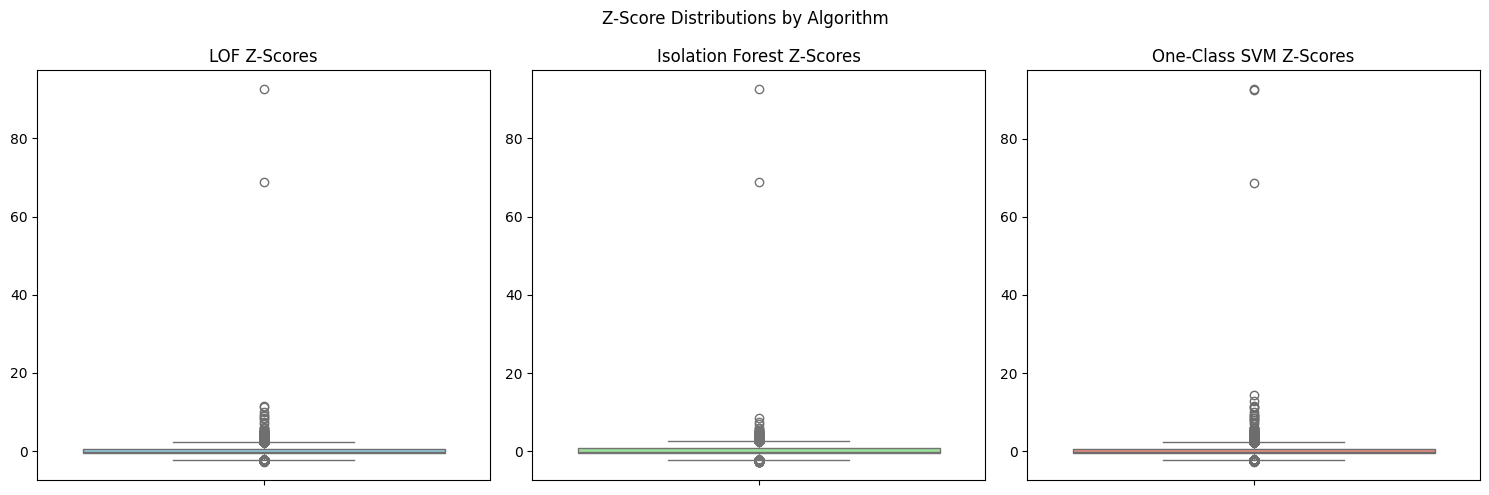

In [ ]:
z_scores_dict = {
    "LOF": z_scores_lof,
    "Isolation Forest": z_scores_iso_for,
    "One-Class SVM": z_scores_oc_svm
}

plot_z_score_distributions(z_scores_dict)

### Temporal analysis

In [6]:
from outliers_code.outliers_analysis import create_temporal_visualizations


plots = create_temporal_visualizations(MergedDataset, MergedDataset.loc[all_outliers_indexes])

plots['heatmap'].show()
